In [ ]:
import pandas as pd
import numpy as np

In [ ]:
sales = pd.DataFrame({
    "date": pd.to_datetime([
        "2025-01-02","2025-01-02","2025-01-03","2025-01-03","2025-01-04","2025-01-04",
        "2025-02-01","2025-02-01","2025-02-02","2025-02-02","2025-02-03","2025-02-03"
    ]),
    "region": ["North","North","South","South","North","South","North","South","North","South","North","South"],
    "channel": ["Online","Store","Online","Store","Store","Online","Online","Online","Store","Store","Online","Store"],
    "category": ["Bikes","Bikes","Accessories","Bikes","Accessories","Accessories","Bikes","Accessories","Bikes","Accessories","Accessories","Bikes"],
    "units": [2, 1, 5, 1, 3, 2, 1, 4, 2, 1, 6, 1],
    "unit_price": [800, 820, 25, 810, 30, 28, 790, 26, 815, 32, 27, 805],
    "discount": [0.05, 0.00, 0.10, 0.00, 0.00, 0.05, 0.00, 0.15, 0.00, 0.00, 0.10, 0.00],
})
 
 
sales.head()

In [7]:
sales.dtypes

date          datetime64[us]
region                   str
channel                  str
category                 str
units                  int64
unit_price             int64
discount             float64
revenue              float64
dtype: object

In [ ]:
sales.describe

In [6]:
# Pajamos po nuolaidos (paprasta formulė)
sales["revenue"] = (sales["units"] * sales["unit_price"] * (1 - sales["discount"])).round(2)
 
sales.head()

,date,region,channel,category,units,unit_price,discount,revenue
0,2025-01-02,North,Online,Bikes,2,800,0.05,1520.0
1,2025-01-02,North,Store,Bikes,1,820,0.00,820.0
2,2025-01-03,South,Online,Accessories,5,25,0.10,112.5
3,2025-01-03,South,Store,Bikes,1,810,0.00,810.0
4,2025-01-04,North,Store,Accessories,3,30,0.00,90.0


In [8]:
# Santrauka per visą lentelę
total_revenue = sales["revenue"].sum().round(2)
avg_units = sales["units"].mean().round(2)
orders_count = len(sales)
 
total_revenue, avg_units, orders_count
 

(np.float64(6896.9), np.float64(2.42), 12)

In [9]:
rev_by_region = sales.groupby("region")["revenue"].sum()
rev_by_region

region
North    4995.8
South    1901.1
Name: revenue, dtype: float64

In [10]:
# Jei rezultato reikia kaip DataFrame
rev_by_region_df = rev_by_region.reset_index(name="total_revenue")
rev_by_region_df

,region,total_revenue
0,North,4995.8
1,South,1901.1


In [11]:
# Pajamos pagal regioną ir kanalą
rev_by_region_channel = (
    sales.groupby(["region", "channel"])["revenue"]
    .sum()
    .sort_values(ascending=False)
)
rev_by_region_channel

region  channel
North   Store      2540.0
        Online     2455.8
South   Store      1647.0
        Online      254.1
Name: revenue, dtype: float64

In [12]:
# MultiIndex -> platus formatas (stulpeliai pagal kanalą)
rev_wide = rev_by_region_channel.unstack(fill_value=0)
rev_wide

channel,Online,Store
region,,
North,2455.8,2540.0
South,254.1,1647.0


In [13]:
# Kelios agregacijos vienam stulpeliui
agg_revenue = sales.groupby("region")["revenue"].agg(["sum", "mean", "count"])
agg_revenue

,sum,mean,count
region,,,
North,4995.8,832.633333,6
South,1901.1,316.850000,6


In [14]:
agg_multi = (
    sales.groupby(["region", "channel"])
    .agg({
        "revenue": ["sum", "mean"],
        "units": ["sum", "mean"],
        "unit_price": "mean",
        "discount": "mean",
    })
)
 
# Patogumui: apvalinimas
agg_multi.round(2)

revenue         units       unit_price discount
                   sum    mean   sum  mean       mean     mean
region channel                                                
North  Online   2455.8  818.60     9  3.00     539.00     0.05
       Store    2540.0  846.67     6  2.00     555.00     0.00
South  Online    254.1   84.70    11  3.67      26.33     0.10
       Store    1647.0  549.00     3  1.00     549.00     0.00

In [15]:
summary = (
    sales.groupby(["region", "channel"])
    .agg(
        total_revenue=("revenue", "sum"),
        avg_revenue=("revenue", "mean"),
        total_units=("units", "sum"),
        avg_units=("units", "mean"),
        avg_price=("unit_price", "mean"),
        avg_discount=("discount", "mean"),
        orders=("revenue", "count"),
    )
    .round(2)
    .reset_index()
)
 
summary

,region,channel,total_revenue,avg_revenue,total_units,avg_units,avg_price,avg_discount,orders
0,North,Online,2455.8,818.60,9,3.00,539.00,0.05,3
1,North,Store,2540.0,846.67,6,2.00,555.00,0.00,3
2,South,Online,254.1,84.70,11,3.67,26.33,0.10,3
3,South,Store,1647.0,549.00,3,1.00,549.00,0.00,3


In [16]:
pivot_rev = pd.pivot_table(
    sales,
    index="region",
    columns="channel",
    values="revenue",
    aggfunc="sum",
    fill_value=0
)
 
pivot_rev

channel,Online,Store
region,,
North,2455.8,2540.0
South,254.1,1647.0


In [17]:
# Tas pats rezultatas kaip pivot lentelėje, tik per groupby + unstack
groupby_like_pivot = (
    sales.groupby(["region", "channel"])["revenue"]
    .sum()
    .unstack(fill_value=0)
)
 
groupby_like_pivot
 

channel,Online,Store
region,,
North,2455.8,2540.0
South,254.1,1647.0


In [18]:
# Paruošiama „plataus“ formato lentelė: pajamos pagal regioną ir kanalą
wide = pivot_rev.reset_index()
wide
 
 

channel,region,Online,Store
0,North,2455.8,2540.0
1,South,254.1,1647.0


In [19]:
# Wide -> Long
long = wide.melt(
    id_vars=["region"],
    var_name="channel",
    value_name="total_revenue"
)
 
long

,region,channel,total_revenue
0,North,Online,2455.8
1,South,Online,254.1
2,North,Store,2540.0
3,South,Store,1647.0


# cia nesaone kur reikia plot naudoti

In [20]:
sales = pd.DataFrame({
    "date": pd.to_datetime([
        "2025-01-01","2025-01-02","2025-01-03","2025-01-04","2025-01-05",
        "2025-01-06","2025-01-07","2025-01-08"
    ]),
    "region": ["North","North","South","South","North","South","North","South"],
    "revenue": [1200, 1500, 900, 1100, 1600, 1000, 1700, 1300]
})
 
sales

,date,region,revenue
0,2025-01-01,North,1200
1,2025-01-02,North,1500
2,2025-01-03,South,900
3,2025-01-04,South,1100
4,2025-01-05,North,1600
5,2025-01-06,South,1000
6,2025-01-07,North,1700
7,2025-01-08,South,1300


NameError: name 'plt' is not defined

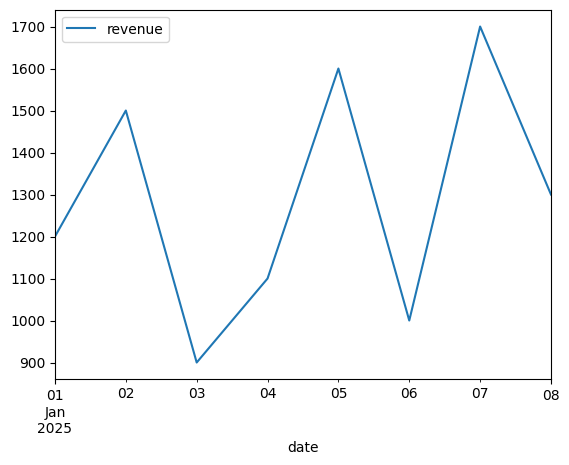

In [23]:
sales.plot(x="date", y="revenue")
plt.show()

# kazkokks kitas tutorialas


In [31]:
data = {
    "date": [
        "2025-01-01", "2025-01-02", "2025-01-03",
        "2025-01-05", "2025-01-06",
        "2025-01-09", "2025-01-10"
    ],
    "revenue": [1200, 1300, 1250, 1400, 1500, 1600, 1550]
}
 
df = pd.DataFrame(data)
df

,date,revenue
0,2025-01-01,1200
1,2025-01-02,1300
2,2025-01-03,1250
3,2025-01-05,1400
4,2025-01-06,1500
5,2025-01-09,1600
6,2025-01-10,1550


In [32]:
df.dtypes

date         str
revenue    int64
dtype: object

In [33]:
df["date_str"] = df["date"].dt.strftime("%Y-%m-%d")
df

AttributeError: Can only use .dt accessor with datetimelike values

In [30]:
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day
df["weekday"] = df["date"].dt.day_name()
 
df

AttributeError: Can only use .dt accessor with datetimelike values

#NAUJAS DARBAS

In [34]:
customers = pd.DataFrame({
    "customer_id": [1, 2, 3, 4],
    "customer_name": ["Asta", "Mantas", "Ieva", "Tomas"],
    "segment": ["Retail", "Retail", "Business", "Retail"]
})
 
orders = pd.DataFrame({
    "order_id": [101, 102, 103, 104, 105],
    "customer_id": [1, 2, 2, 3, 5],  # customer_id=5 neturi atitikmens customers lentelėje
    "product_id": [10, 10, 11, 12, 12],
    "quantity": [1, 2, 1, 3, 1]
})
 
products = pd.DataFrame({
    "product_id": [10, 11, 12],
    "product_name": ["Bike", "Helmet", "Bottle"],
    "unit_price": [800, 50, 12]
})
 
customers, orders, products

(   customer_id customer_name   segment
 0            1          Asta    Retail
 1            2        Mantas    Retail
 2            3          Ieva  Business
 3            4         Tomas    Retail,
    order_id  customer_id  product_id  quantity
 0       101            1          10         1
 1       102            2          10         2
 2       103            2          11         1
 3       104            3          12         3
 4       105            5          12         1,
    product_id product_name  unit_price
 0          10         Bike         800
 1          11       Helmet          50
 2          12       Bottle          12)

In [35]:
# INNER JOIN: užsakymai + klientai (paliekami tik tie užsakymai, kurių klientas egzistuoja customers lentelėje)
orders_inner = orders.merge(customers, on="customer_id", how="inner")
orders_inner

,order_id,customer_id,product_id,quantity,customer_name,segment
0,101,1,10,1,Asta,Retail
1,102,2,10,2,Mantas,Retail
2,103,2,11,1,Mantas,Retail
3,104,3,12,3,Ieva,Business


In [36]:
# LEFT JOIN: paliekami visi užsakymai, net jei klientas nerandamas
orders_left = orders.merge(customers, on="customer_id", how="left")
orders_left

,order_id,customer_id,product_id,quantity,customer_name,segment
0,101,1,10,1,Asta,Retail
1,102,2,10,2,Mantas,Retail
2,103,2,11,1,Mantas,Retail
3,104,3,12,3,Ieva,Business
4,105,5,12,1,NaN,NaN


In [37]:
# Paruošiamas indeksas
customers_idx = customers.set_index("customer_id")
 
# join pagal customer_id (iš orders pusės)
orders_join = orders.join(customers_idx, on="customer_id", how="left")
orders_join

,order_id,customer_id,product_id,quantity,customer_name,segment
0,101,1,10,1,Asta,Retail
1,102,2,10,2,Mantas,Retail
2,103,2,11,1,Mantas,Retail
3,104,3,12,3,Ieva,Business
4,105,5,12,1,NaN,NaN


In [38]:
orders_enriched = (
    orders
    .merge(customers, on="customer_id", how="left")
    .merge(products, on="product_id", how="left")
)
 
 
orders_enriched

,order_id,customer_id,product_id,quantity,customer_name,segment,product_name,unit_price
0,101,1,10,1,Asta,Retail,Bike,800
1,102,2,10,2,Mantas,Retail,Bike,800
2,103,2,11,1,Mantas,Retail,Helmet,50
3,104,3,12,3,Ieva,Business,Bottle,12
4,105,5,12,1,NaN,NaN,Bottle,12


In [39]:
orders_enriched["revenue"] = (orders_enriched["quantity"] * orders_enriched["unit_price"]).round(2)
 
orders_enriched

,order_id,customer_id,product_id,quantity,customer_name,segment,product_name,unit_price,revenue
0,101,1,10,1,Asta,Retail,Bike,800,800
1,102,2,10,2,Mantas,Retail,Bike,800,1600
2,103,2,11,1,Mantas,Retail,Helmet,50,50
3,104,3,12,3,Ieva,Business,Bottle,12,36
4,105,5,12,1,NaN,NaN,Bottle,12,12
